In [13]:
import os
import csv
import math
import itertools

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from scipy import sparse
import networkx as nx

from mbi import (
    Dataset,
    FactoredInference,
    Domain,
    LocalInference,
    MixtureInference,
    PublicInference,
)

In [14]:
data = Dataset.load("data/diabetes_processed.csv", "data/diabetes_processed.json")

In [15]:
N = data.df.shape[0]
df = pd.DataFrame(columns=['col1','col2', 'score'])
idx = 0

In [16]:
# source: https://github.com/usnistgov/PrivacyEngCollabSpace/blob/master/tools/de-identification/Differential-Privacy-Synthetic-Data-Challenge-Algorithms/rmckenna/select-queries.ipynb

# calculate mutual info between every pair of attributes

for a,b in itertools.combinations(data.domain.attrs, 2):
    A = data.project(a).datavector() / N
    B = data.project(b).datavector() / N
    AB = data.project([a,b]).datavector() / N
    nz = AB > 0

    score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
    # print(a,b,score)
    df.loc[idx] = [a,b,score]
    df.loc[idx+1] = [b,a,score]
    idx += 2

df = df.sort_values('score')


/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_41821/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_41821/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_41821/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_41821/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_41821/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])


In [17]:
df.head()

,col1,col2,score
3,hypertension,gender,0.000117
2,gender,hypertension,0.000117
12,gender,blood_glucose_level,0.000388
13,blood_glucose_level,gender,0.000388
10,gender,HbA1c_level,0.000493


In [18]:
nodes = data.domain.attrs
weights = df[df.col1.isin(nodes) & df.col2.isin(nodes)]
weights.head()

,col1,col2,score
3,hypertension,gender,0.000117
2,gender,hypertension,0.000117
12,gender,blood_glucose_level,0.000388
13,blood_glucose_level,gender,0.000388
10,gender,HbA1c_level,0.000493


In [19]:
G = nx.Graph()
G.add_nodes_from(nodes)

for e1, e2, w in zip(weights['col1'], weights['col2'], weights['score']):
    G.add_edge(e1, e2, weight=w)

mst = nx.maximum_spanning_tree(G)

es = list(mst.edges)
print(es)
print(len(es))

[('gender', 'bmi'), ('age', 'bmi'), ('age', 'hypertension'), ('age', 'heart_disease'), ('smoking_history', 'bmi'), ('bmi', 'blood_glucose_level'), ('bmi', 'HbA1c_level'), ('HbA1c_level', 'diabetes')]
8


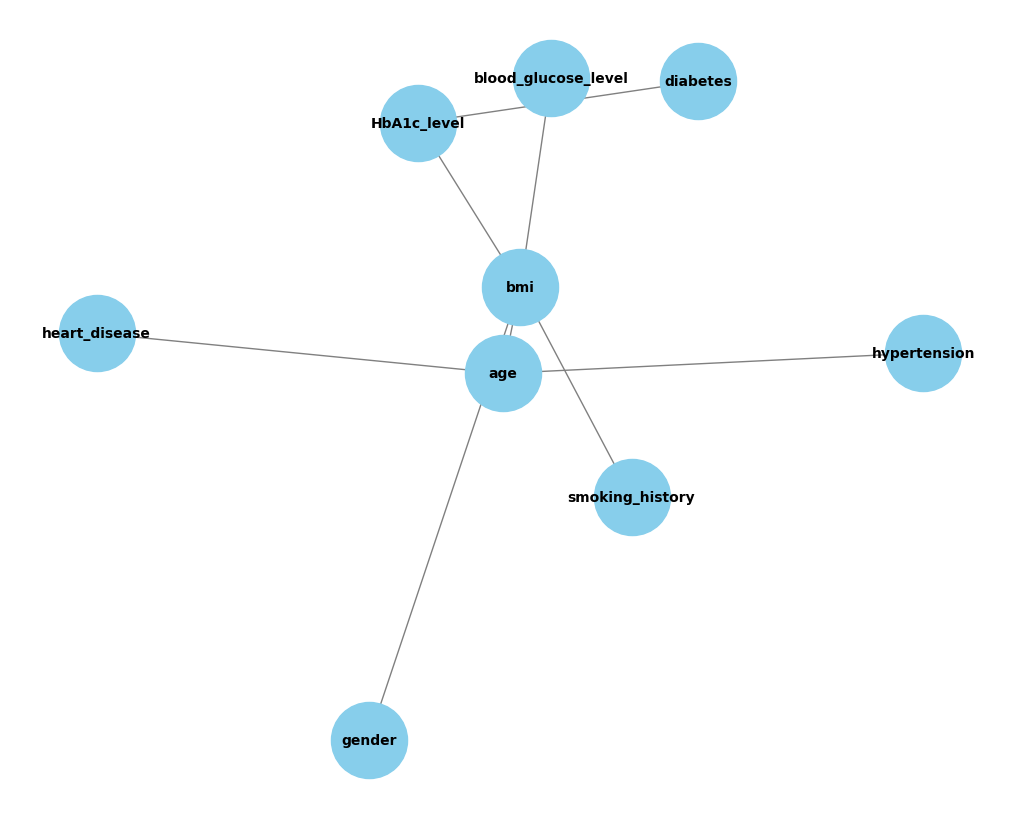

In [20]:
plt.figure(figsize=(10, 8))  # Set the figure size
pos = nx.spring_layout(G)  # Use spring layout for positioning nodes
nx.draw(mst, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=10, font_weight='bold', edge_color='gray')

# Show the plot
plt.show()

In [ ]:
df = pd.DataFrame(columns=['col1','col2', 'score', 'bound'])
idx = 0

entropies = {key: -1 for key in data.domain.attrs}

for attr in data.domain.attrs:
    # Calculate probabilities
    probabilities = data.df[attr].value_counts(normalize=True)
    # Calculate Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))

    entropies[attr] = entropy

for a,b in itertools.combinations(data.domain.attrs, 2):
    A = data.project(a).datavector() / N
    B = data.project(b).datavector() / N
    AB = data.project([a,b]).datavector() / N
    nz = AB > 0

    score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
    df.loc[idx] = [a,b,score,min(entropies[a],entropies[b])]
    idx += 1

df = df.sort_values('score')

df = df[df['score'] > df['bound'] * 0.1]
df

/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_41821/4216992792.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_41821/4216992792.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_41821/4216992792.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_41821/4216992792.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_41821/4216992792.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])


,col1,col2,score,bound
9,age,heart_disease,0.034293,0.239627
8,age,hypertension,0.039441,0.383768
32,bmi,diabetes,0.045808,0.419556
35,blood_glucose_level,diabetes,0.112074,0.419556
34,HbA1c_level,diabetes,0.129815,0.419556
11,age,bmi,1.084715,6.318115


In [22]:
tuple_list = list(zip(df['col1'], df['col2']))
es.extend(tuple_list)
es = list(set(es))
print(es)
print(len(es))

[('bmi', 'HbA1c_level'), ('HbA1c_level', 'diabetes'), ('age', 'bmi'), ('bmi', 'diabetes'), ('blood_glucose_level', 'diabetes'), ('smoking_history', 'bmi'), ('bmi', 'blood_glucose_level'), ('gender', 'bmi'), ('age', 'hypertension'), ('age', 'heart_disease')]
10


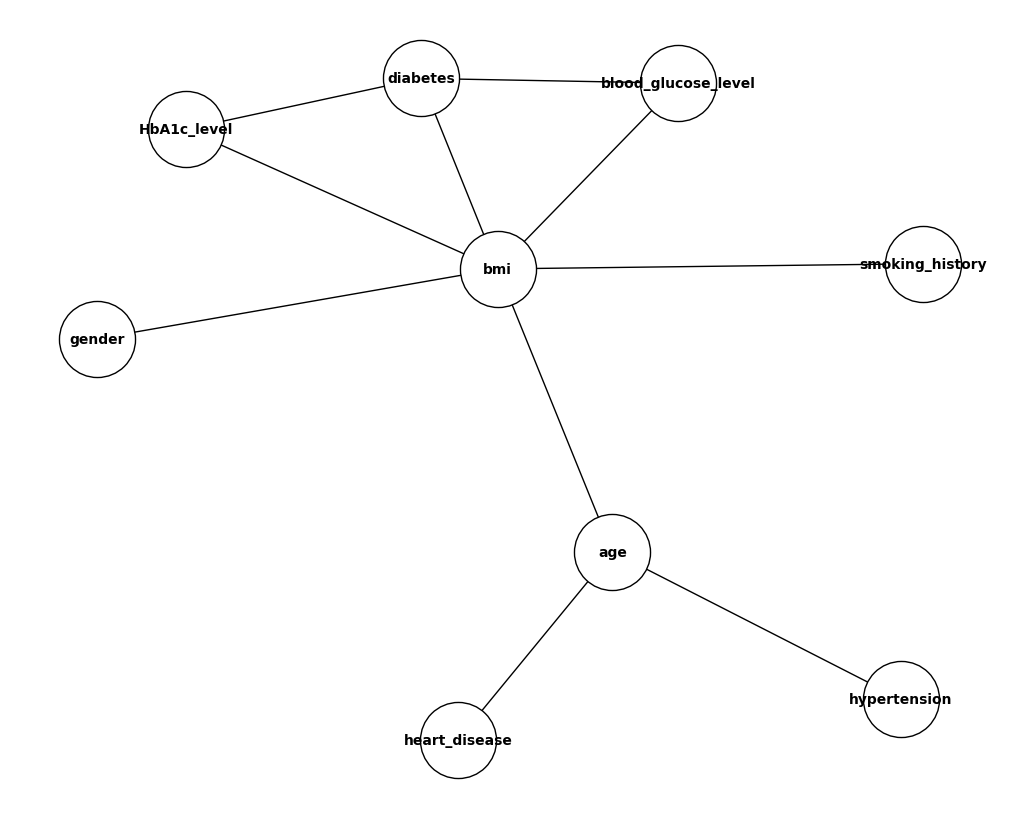

In [23]:
# Create a directed graph
G = nx.Graph()

# Add edges to the graph
G.add_edges_from(es)

plt.figure(figsize=(10, 8))  # Set the figure size
pos = nx.spring_layout(G)  # Use spring layout for positioning nodes
nx.draw(G, pos, with_labels=True, node_color='white', node_size=3000, font_size=10, font_weight='bold', edge_color='black', node_shape='o', edgecolors='black')

# Save the figure as a PDF
plt.savefig("paper/images/diabetes_mst.pdf", format="pdf", bbox_inches='tight')  # Specify the format as PDF

# Show the plot
plt.show()

In [24]:
cliques = list(nx.find_cliques(G))
for c in cliques:
    print(c)

['bmi', 'gender']
['bmi', 'smoking_history']
['bmi', 'diabetes', 'HbA1c_level']
['bmi', 'diabetes', 'blood_glucose_level']
['bmi', 'age']
['hypertension', 'age']
['heart_disease', 'age']
